In [2]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

/Users/natasha.santoso/Library/Python/3.8/lib/python/site-packages/qiskit/chemistry/__init__.py:170: DeprecationWarning: The package qiskit.chemistry is deprecated. It was moved/refactored to qiskit_nature (pip install qiskit-nature). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('chemistry', 'qiskit_nature', 'qiskit-nature')
/Users/natasha.santoso/Library/Python/3.8/lib/python/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [3]:
# distance in 3D -{} -> distance that will be varied
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
distances = np.arange(0.5, 4.25, 0.25)
# distance from ... to ... in Angstorm, and interval in Angstorm
vqe_energies = [] # ground state energy calc by VQE
hf_energies = [] # calc from HartreeFock guess
exact_energies = [] # calculated by numpy eigen solver

In [6]:
for i,d in enumerate(distances):
    print('step', i)
    
    # set up experiment
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
    qmolecule = driver.run()
    # encode molecule to Quantum Computer
    operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
                          two_qubit_reduction=True,
                          freeze_core=True,
                          orbital_reduction=[-3,-2])
    qubit_op, aux_ops = operator.run(qmolecule)
    
    # exact classical result
    exact_result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run()
    exact_result = operator.process_algorithm_result(exact_result)
    
    # VQE
    optimizer = SLSQP(maxiter=1000)
    initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                               operator.molecule_info['num_particles'],
                               qubit_mapping=operator._qubit_mapping,
                               two_qubit_reduction=operator._two_qubit_reduction)
    var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                    num_particles=operator.molecule_info['num_particles'],
                    initial_state=initial_state,
                    qubit_mapping=operator._qubit_mapping,
                    two_qubit_reduction=operator._two_qubit_reduction)
    algo = VQE(qubit_op, var_form, optimizer, aux_operators = aux_ops)
    
    vqe_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    vqe_result = operator.process_algorithm_result(vqe_result)
    
    exact_energies.append(exact_result.energy)
    vqe_energies.append(vqe_result.energy)
    hf_energies.append(vqe_result.hartree_fock_energy)

step 0


/var/folders/7j/_yrz2d6s5y9dqjwr_2s9vvq00000gn/T/ipykernel_2425/4036196585.py:8: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
/Users/natasha.santoso/Library/Python/3.8/lib/python/site-packages/qiskit/chemistry/core/hamiltonian.py:88: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/Users/natasha.santoso/Library/Python/3.8/lib/python/site-packages/qiskit/chemistry/components/initial_states/hartree_fock.py:61: DeprecationWarning: The HartreeFock class is deprecated as of Aqua 0.9 and will be removed no earlier than 3 months after the releas

step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14


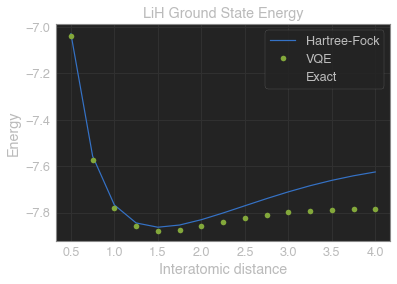

In [7]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
pylab.plot(distances, vqe_energies, 'o', label='VQE')
pylab.plot(distances, exact_energies, 'x', label='Exact')

pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right')